# Training pipeline for arutema47 model.

The model and image tile preparation is based on public kernels.

* Most important part is using the denoised training labels.
* model efficientnet-b0
* Original augumentations for better generization (specifics in the dataloader sections.

In [1]:
kernel_type = 'efficientnet-b0'
modelname = kernel_type

fold = 0
tile_size = 256
image_size = 256
n_tiles = 36
batch_size = 3
num_workers = 8
out_dim = 5
init_lr = 1e-4
warmup_factor = 10
n_epochs = 30

load_raw_png = False
load_jpg = False

mixup = True
cutmix = False

# Cosine annealing or exp scheduler
COSINE = True
EXP = False
if not COSINE:
    EXP = True

poolmethod = "avgpool"

kernel_type += "famlabelsmodelsub_{}_tile{}_imsize{}".format(poolmethod, n_tiles, image_size)
if mixup:
    kernel_type += "_mixup"
if cutmix:
    kernel_type += "_cutmix"

In [2]:
DEBUG = False

In [3]:
import os
import sys

# make dirs
os.makedirs("models", exist_ok=True)
os.makedirs("log", exist_ok=True)

In [4]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
#from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm
import torchvision


In [5]:
# Fix SEED
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

# We use the denoised training data

In [6]:
data_dir = './input/'
# load clean labels
df_train = pd.read_csv("./output/model/final_1/local_preds_final_1_efficientnet-b1_removed_noise_thresh_16.csv")
image_folder = os.path.join(data_dir, 'train_256_36')

warmup_epo = 1

df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')
print(os.getcwd())
print(image_folder)

/home/val/Downloads/Kaggle-PANDA-1st-place-solution
./input/train_256_36


In [7]:
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,kfold,probs_raw,probs_without_tta_raw,preds,preds_without_tta
0,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,1,0.020964,0.025039,0,0
1,003a91841da04a5a31f808fb5c21538a,karolinska,1,3+3,1,1.042482,1.044420,1,1
2,004dd32d9cd167d9cc31c13b704498af,radboud,1,3+3,1,1.163072,1.184651,1,1
3,004f6b3a66189b4e88b6a01ba19d7d31,karolinska,1,3+3,1,2.210813,2.346966,2,2
4,00a26aaa82c959624d90dfb69fcf259c,radboud,4,4+4,1,3.559884,3.723556,4,4


# Create Folds

In [8]:
def erase(df_train):
    df_train2 = df_train
    erase = []
    for i, id in enumerate(df_train2["image_id"].to_numpy()):
        if not os.path.isfile(os.path.join(image_folder, f'{id}.npz')):
            erase.append(i)
            pass
        #img = cv2.imread(os.path.join(image_folder, f'{id}.png'))
        
    return df_train.drop(erase)

df_train = erase(df_train).reset_index()

In [9]:
df_train = df_train.drop("index", 1)
len(df_train)

10013

In [10]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i

df_train.tail()

,image_id,data_provider,isup_grade,gleason_score,kfold,probs_raw,probs_without_tta_raw,preds,preds_without_tta,fold
10008,ff228af5af1389e09e293692ea479d98,radboud,4,4+4,5,4.365540,4.469392,4,4,2
10009,ff30f31f767ae4d18f5145598f46f5fd,radboud,5,4+5,5,3.728697,3.714015,4,4,0
10010,ff328f9aacb5c8844fb3907c5da69c77,karolinska,0,0+0,5,0.211002,0.195072,0,0,2
10011,ff602bd9652640d4b534d7a78fc64b6a,karolinska,0,0+0,5,0.024534,0.028135,0,0,2
10012,ff79f700dc97b2fd05d92e56f4b4a815,karolinska,0,0+0,5,0.178487,0.174824,0,0,1


In [11]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

# Model.

The model is based on a public kernel:

https://www.kaggle.com/haqishen/train-efficientnet-b0-w-36-tiles-256-lb0-87

In [12]:
from torchvision.ops import misc as misc_nn_ops
from torchvision.models import resnet
from efficientnet_pytorch import EfficientNet

class enetv2(nn.Module):
    def __init__(self, out_dim=5, freeze_bn=True):
        super(enetv2, self).__init__()
        self.basemodel = EfficientNet.from_pretrained(modelname) 
        self.myfc = nn.Linear(self.basemodel._fc.in_features, out_dim)
        self.basemodel._fc = nn.Identity()        
            
    def extract(self, x):
        return self.basemodel(x)

    def forward(self, x):
        x = self.basemodel(x)
        x = self.myfc(x)
        return x

In [13]:
enetv2()

Loaded pretrained weights for efficientnet-b0


enetv2(
  (basemodel): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_pro

# Dataset

Tile preparation is also based on the public kernel.
https://www.kaggle.com/haqishen/train-efficientnet-b0-w-36-tiles-256-lb0-87


Augumentations are different and important.

* We add cutouts, rotations augumentation for better generization.
* We add mixup augumentation for training for better generization.

mixup: Beyond Empirical Risk Minimization

https://arxiv.org/abs/1710.09412

For mixup, I simply made an another tile and mixed two images.
I just implemented mixup from the original paper, but some implementation can be found from Bengali contests.



In [14]:
def rand_bbox(size, lam):
    W = size[1]
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [15]:
def get_tiles(img, mode=0, transform=None):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        ).astype(np.float32)

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        img3 = (img3*255).astype(np.uint8)
        for i in range(len(img3)):
            if transform is not None:
                img3[i] = transform(image=img3[i])['image']
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        if load_raw_png:
            tiff_file = os.path.join(image_folder, f'{img_id}.jpg')
            image = cv2.imread(tiff_file)
            if self.transform is not None:
                tiles, OK = get_tiles(image, self.tile_mode, self.transform)
            else:
                tiles, OK = get_tiles(image, self.tile_mode)

            if self.rand:
                idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
            else:
                idxes = list(range(self.n_tiles))

            n_row_tiles = int(np.sqrt(self.n_tiles))
            images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
            for h in range(n_row_tiles):
                for w in range(n_row_tiles):
                    i = h * n_row_tiles + w

                    if len(tiles) > idxes[i]:
                        this_img = tiles[idxes[i]]['img']
                    else:
                        this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                    this_img = 255 - this_img
                    if self.transform is not None:
                        this_img = self.transform(image=this_img)['image']
                    h1 = h * image_size
                    w1 = w * image_size
                    images[h1:h1+image_size, w1:w1+image_size] = this_img
                    images = (images*255).astype(np.uint8)
        elif load_jpg:            
            file = os.path.join("train_{}_{}_aug".format(self.image_size, self.n_tiles), f'{img_id}_{np.random.randint(0,9)}.jpg')
            images = cv2.imread(file)
        else:
            file = os.path.join("./input/train_{}_{}".format(self.image_size, self.n_tiles), f'{img_id}.npz')
            images = np.load(file)["arr_0"]
            images = images.transpose(2, 0, 1)
        
        # Load labels
        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
        
        # Mixup part
        rd = np.random.rand()
        if mixup and rd < 0.3 and self.transform is not None:
            mix_idx = np.random.random_integers(0, len(self.df))
            row2 = self.df.iloc[mix_idx]
            img_id2 = row2.image_id
            file = os.path.join("./input/train_{}_{}".format(self.image_size, self.n_tiles), f'{img_id2}.npz')
            images2 = np.load(file)["arr_0"]
            images2 = images2.transpose(2, 0, 1)
            
            if self.transform is not None:
                images2 = self.transform(image=images2)['image']
            
            # blend image
            gamma = np.random.beta(1,1)
            images = ((images*gamma + images2*(1-gamma))).astype(np.uint8)
            # blend labels
            label2 = np.zeros(5).astype(np.float32)
            label2[:row2.isup_grade] = 1.
            label = (label*gamma+label2*(1-gamma))
        
        # Also tried cutmix, does not work well. Maybe because tile includes important information partially.
        elif cutmix and rd > 0.7 and self.transform is not None:
            #print("cutmix")
            mix_idx = np.random.random_integers(0, len(self.df))
            row2 = self.df.iloc[mix_idx]
            img_id2 = row2.image_id
            file = os.path.join("train_{}_{}".format(self.image_size, self.n_tiles), f'{img_id2}.npz')
            images2 = np.load(file)["arr_0"]
            images2 = images2.transpose(2, 0, 1)
            
            # blend image
            gamma = np.random.beta(1,1)
            bbx1, bby1, bbx2, bby2 = rand_bbox(images.shape, gamma)
            images[:, bbx1:bbx2, bby1:bby2] = images2[:, bbx1:bbx2, bby1:bby2]
            # adjust lambda to exactly match pixel ratio
            gamma = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.shape[-1] * images.shape[-2]))
            # blend labels
            label2 = np.zeros(5).astype(np.float32)
            label2[:row2.isup_grade] = 1.
            label = (label*gamma+label2*(1-gamma))
            #print(label)
        
        
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        
        return torch.tensor(images), torch.tensor(label)


In [16]:
np.random.beta(1,1)

0.5000386523859661

In [17]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=None)
images, label = dataset_show[0]

In [18]:
images.shape

torch.Size([1536, 3, 1536])

## Augmentations by Albumentations

In [19]:
import albumentations as A
transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.25, rotate_limit=180,p=0.5),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                             val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, 
                                   contrast_limit=0.2, p=0.5),
    ],p=0.9),
    A.Cutout(num_holes=36, max_h_size=128, max_w_size=128, fill_value=0, p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
])
transforms_val = albumentations.Compose([])

error: OpenCV(4.2.0) /io/opencv/modules/core/src/copy.cpp:998: error: (-215:Assertion failed) _src.dims() <= 2 in function 'flip'


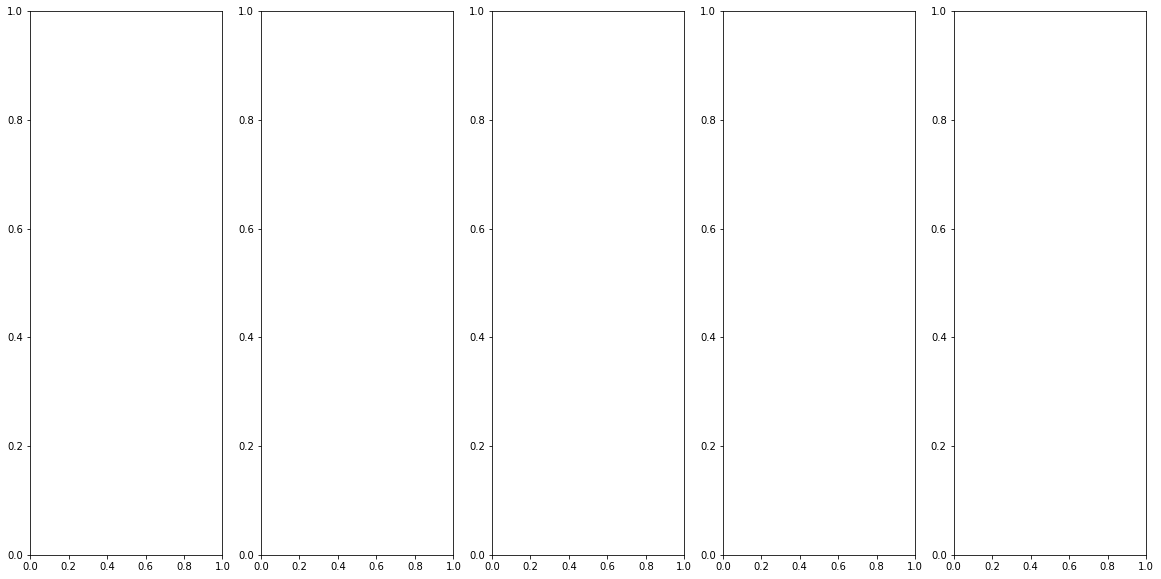

In [20]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))


# Loss

In [ ]:
criterion = nn.BCEWithLogitsLoss()

# Train & Val

In [ ]:
def train_epoch(loader, optimizer):

    model.eval()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)
    
    if EXP:
        scheduler.step(val_loss)
    
    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk, qwk_k, qwk_r, PREDS, TARGETS

    

# Create Dataloader & Model & Optimizer

## 5-fold models are trained.

In [ ]:
for fold in range(0,5):
    train_idx = np.where((df_train['fold'] != fold))[0]
    valid_idx = np.where((df_train['fold'] == fold))[0]

    df_this  = df_train.loc[train_idx]
    df_valid = df_train.loc[valid_idx]

    df_this = df_this.reset_index()
    df_valid = df_valid.reset_index()

    dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
    dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=None)
    
    # Setup dataloader
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

    # Initialize model
    model = enetv2(out_dim=out_dim)
    model = model.to(device)

    print(len(dataset_train), len(dataset_valid))

    # We use Cosine annealing LR scheduling
    if COSINE:
        optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
        scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
        scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
    else:
        optimizer = optim.Adam(model.parameters(), lr=init_lr)
        from torch.optim import lr_scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, verbose=True, min_lr=1e-3*1e-5, factor=0.5)

    qwk_max = 0.
    os.makedirs("models", exist_ok=True)
    os.makedirs("log", exist_ok=True)
    best_file = f'./models/{kernel_type}_best_fold{fold}.pth'
    for epoch in range(1, n_epochs+1):
        torch.cuda.empty_cache() 
        print(time.ctime(), 'Epoch:', epoch)
        if COSINE:
            scheduler.step(epoch-1)

        train_loss = train_epoch(train_loader, optimizer)
        val_loss, acc, qwk, qwk_k, qwk_r, TARGETS, PREDS = val_epoch(valid_loader)

        content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f},     qwk: {(qwk):.5f}, qwk_k: {(qwk_k):.5f}, qwk_r: {(qwk_r):.5f}'
        print(content)
        with open(f'log/log_{kernel_type}_fold{fold}.txt', 'a') as appender:
            appender.write(content + '\n')
        
        from sklearn.metrics import cohen_kappa_score,confusion_matrix
        cmat = confusion_matrix(TARGETS, PREDS).astype("uint")
        cmat

        with open(f'log/logcmat_{kernel_type}_fold{fold}.txt', 'a') as appender:
            appender.write("epoch:" + str(epoch) + '\n')
            np.savetxt(appender, cmat, fmt='%3d')
            
        # use 20th epoch results as final to prevent overfitting.
        if epoch==20:
            torch.save(model.state_dict(), os.path.join(f'models/{kernel_type}_final_epoch{epoch}_fold{fold}.pth'))
            break